# Bayesian Baseball Monkeys

The MARCEL baseball projection model, developed by Tom Tango, is a simple yet effective forecasting system for Major League Baseball (MLB) player performance. Named humorously after Marcel the Monkey, the system is designed to use minimal intelligence, making it straightforward and accessible.

![monkey](assets/Marcel-the-Monkey.png)

### Key Features of the MARCEL Model

1. **Data Utilization**:
   - The model uses three years of MLB data, with the most recent year weighted more heavily. This approach ensures that the projections are based on a player's recent performance while still considering their historical data.

2. **Regression to the Mean**:
   - MARCEL incorporates a regression towards the mean, which helps to temper extreme performances and provide more balanced projections.

3. **Age Factor**:
   - The model includes an age factor to account for the natural aging process of players, which can affect their performance.

4. **Simplicity and Accessibility**:
   - The system is designed to be as simple as possible, aiming to represent the "minimum level of competence" that should be expected from any forecaster. This simplicity is part of its charm and effectiveness.

### Practical Use and Limitations

Understandably, Tom Tango does not stand behind these forecasts as definitive predictions but rather as a baseline. He emphasizes that while MARCEL works, it is not designed to be the most sophisticated system available. The model serves as a trustee system, providing a reliable starting point for player projections without requiring extensive computational resources or complex algorithms.


## A Bayesian Marcel?

An interesting exercise is to consider how we might extend the MARCEL by implementing it using Bayesian methods. By incorporating a Bayesian framework, we can introduce uncertainty estimates into the projections, which can be valuable for decision-making and risk assessment. 

In the spirit of MARCEL, the goal here is not to have a sophisticated model for making accurate projections, but rather to have a simple, general purpose model that can be used to project arbitrary metrics, usually intended to provide baseline one-year-ahead projections. The only difference is that we will now have probabilistic uncertainty estimates around the resulting projections.

To this end, there are only three core components to the model:

1. Weights for previous seasons, estimated from the data.
2. A simple aging function
3. A hierarchical random effect for shrinking inputs toward the population mean when data are sparse.

## Model description

For pitcher $i$ having observed values of some quantity of interest in three consecutive years $y_i^{(t)}, y_i^{(t-1)}, y_i^{(t-2)}$ we are predicting $y_i^{(t+1)}$ via:

$$\theta_i^{(t+1)} = \mu_i + w_0 (\theta_i^{(t)}) + w_1 (\theta_i^{(t-1)}) + w_2 (\theta_i^{(t-2)}) + \beta_{28} a_i^{(t+1)}$$

where $\{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$ are constrained to be ordered and the $\theta_i$ are partially pooled observations to regress extreme values. For Gaussian data, the likelihood is:

$$y_i^{(t)} \sim N(\theta_i^{(t)}, \sigma)$$

For other types of data, this likelihood may be binomial or Poisson.

The coefficient $\beta_{28}$ is a simple triangular aging model that is piecewise linear with a switch point at 28 years of age.

All inputs are automatically standardized to aid in convergence.

## Using Motuba

The API for Motuba is stolen directly from `scikit-learn`. It is an object-oriented interface, which involves creating an instance of a `Motuba` model, calling the `fit()` method to fit the model, and then calling the `predict()` method to make predictions.

Below are a couple of examples that show how Motuba can be used:

In [1]:
import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
from motuba import Motuba

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data Preparation

In order to keep things tidy, `Motuba` expects pandas `DataFrame` and `Series` objects as input (for predictors and targets, respectively) when fitting and predicting. 

For this example, we will use some pitching data to demonstrate how the model works.

In [4]:
input_data = (pitch_usage.join(stuff_values, lsuffix="_n", rsuffix="_stuff").join(
        df.drop_duplicates(subset=["pitcher_id", "season"]).set_index(
            ["pitcher_id", "season"]
        )[["age", "pitcher_name"]]
    )
).reset_index()

input_data.head()

,pitcher_id,season,BB_n,FB_n,OS_n,BB_stuff,FB_stuff,OS_stuff,age,pitcher_name
0,112526,2016,177,2501,119,-0.000362,0.004713,0.003833,43,"Colon, Bartolo"
1,112526,2017,173,1885,222,-0.000385,0.005473,0.003863,44,"Colon, Bartolo"
2,112526,2018,225,1753,248,0.000370,0.006537,0.005597,45,"Colon, Bartolo"
3,150274,2016,46,70,3,-0.005253,0.003864,0.005427,42,"Nathan, Joe"
4,276351,2016,372,648,26,-0.005756,-0.000349,-0.004083,40,"Grilli, Jason"


As is common to most statistical or machine learning modeling workflows, there are (at least) two distinct stages to the analysis: a **model fitting** stage and a **prediction** stage. With Motuba, the model fitting stage will include three time steps of input data (here we are dealing with annual summary data, but can be months, weeks, games or any other unit) and a fourth subsequent time step that we have observed and are using as a target for prediction. Having fit the model, the prediction stage uses just three time steps of input data, and then tries to predict the fourth stage. In machine learning parlance, you often hear the model fitting data called the **training set** and the prediction data called the **test set**. 

To make this concrete, we may fit a model using 2019-2021 data with 2022 as a target outcome, and then use 2020-2022 inputs to generate predictions for 2023. In principle, the inputs need not be the same three time periods -- you could use 2017-2019 or any other three periods for which you have observations of a fourth.

The data above shows stuff scores for each of three general pitch types, where each row is a pitcher-year. For use with Motuba, this data needs to be broken into 4 data structures:

1. a grid of input data observations and player ages
2. a grid of sample sizes corresponding with each observation in (1)
3. a vector of target data observations (model fitting only)
4. a vector of target data sample sizes (model fitting only)

Since we are using Python, the data grids will be pandas `DataFrame` objects and vectors will be `Series` objects. A key feature of these data structures is that both have an `index` that uniquely represents players corresponding to the rows of data. The indices should be some unique identifier, commonly a `bam_id` or even a player name (it need not be numeric).

The input grid should have 4 columns, consisting of the following:

- three columns representing data from consecutive time periods prior to the prediction time
- a column of ages corresponding to ages in the prediction year

These columns can be named anything you like, and the name of the age column will be passed explicitly to the model, as you will see.

Let's look at fastball stuff

In [5]:
pred_year = 2021
var_name = 'FB_stuff'
n_var_name = 'FB_n'

So, we will be using years 2018-2020 to fit to 2021 outcomes, where the values are fastball stuff estimates. The sample size will be the number of fastballs thrown by each pitcher in each year. 

For convenience, we are using players who have complete data over all 4 seasons.

In [6]:
input_grid = (
    input_data[
        input_data.season.isin(np.arange(pred_year - 3, pred_year + 1))
    ]
    .pivot(index="pitcher_id", columns="season", values=var_name)
    .dropna()
    .astype(input_data[var_name].dtype)
)
n_grid = (
    input_data[
        input_data.season.isin(np.arange(pred_year - 3, pred_year + 1))
    ]
    .pivot(index="pitcher_id", columns="season", values=n_var_name)
    .loc[input_grid.index]
    .astype(int)
)

y = input_grid.pop(pred_year)
X = input_grid[np.arange(pred_year - 3, pred_year)]
N_x = n_grid[np.arange(pred_year - 3, pred_year)]
N_y = n_grid[pred_year]
X["age"] = (
    input_data[input_data.season == pred_year]
    .set_index("pitcher_id")
    .age.loc[input_grid.index]
)

Its helpful to be familiar with the pandas [`pivot` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) when you reshape the data!

In [7]:
X.head()

season,2018,2019,2020,age
pitcher_id,,,,
424144,0.001258,-0.000809,0.002032,40
425794,0.008061,0.009068,0.011001,40
425844,0.005681,0.006300,0.003571,38
433589,0.005343,0.005318,0.004676,37
445213,0.006462,0.004617,0.007440,37


Notice in the above that `pitcher_id` is the `index`. The values do not need to be scaled in any way--Motuba will do this under the hood automatically as needed.

In [8]:
y.head()

pitcher_id
424144    0.004205
425794    0.013272
425844    0.010192
433589    0.006339
445213    0.008103
Name: 2021, dtype: float64

Since the response variable is just an additional year of data, it is in a `Series` object (though a one-column `DataFrame` ought to work as well). Notice that the index is the same.

In [9]:
assert (y.index==X.index).all()

For this example, I'm just going to use a subset of the whole dataset for fitting and a (much smaller) subset for prediction, as you typically see in traditional machine learning validation exercises. Specifically, I will do a 80:20 split:

In [10]:
all_pitchers = X.index.unique().values
fit_pitchers = all_pitchers[:int(len(all_pitchers)*0.8)]
pred_pitchers = all_pitchers[int(len(all_pitchers)*0.8):]

We are now ready to initialize a model. Again, Motuba uses a scikit-learn-like API, which first involves creating an **instance** of Motuba. This involves providing some information about your model, and getting an initialized `Motuba` object in return that can be used for fitting and projecting.

As a user, you specify 1-3 arguments for the initialization:

- `total_players`: the total number of players to be involved in the analysis, both in the fitting and predicting steps.
- `model_type`: the type of model to be fit (discussed below)
- `peak_age`: the inflection point in age where player performance begins to decline

Only `total_players` is a required argument. If you do not specify a `model_type` then a "normal" model will be assumed and if you do not specify a `peak_age` then age 28 will be used as a default.



In [11]:
fb_stuff_model = Motuba(model_type='normal')

We now have an instantiated `Motuba` object:

In [12]:
fb_stuff_model

The next step is model fitting: this is where we pass the data to the model and let it do its thing. There needs to be four data structures passed to `fit`, including input values and sample sizes (the "X" values and their associated weights) and the target values and their sample sizes (the "y" values and weights).

In [13]:
X_fit = X.loc[fit_pitchers]
y_fit = y.loc[fit_pitchers]

N_x_fit = N_x.loc[fit_pitchers]
N_y_fit = N_y.loc[fit_pitchers]

The other input of interest is the column name of the age variable to be used in fitting a triangular aging curve. The default for this is "age", but you can call it whatever you like as long as you pass it to `fit` as the `age_col` argument. I've included it here just to be explicit.

In [14]:
fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z, sigma, w, beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 50 seconds.


Fitting them model can take anywhere from seconds to hours, depending on how much data you are using. This example should only take a couple of minutes on a modern machine like an M1 Mac.

What you see above is the output from the underlying PyMC model being fit using Markov chain Monte Carlo (specifically, the NUTS algorithm). You want to keep an eye on this output for any warning messages that may require additional intervention in order to improve the model. This example should run fine under the default conditions.

## Model Checking

Even in the absence of warnings, its always important to check your model. In model checking, we want to know at least two things: did the model fitting algorithm work, and does the model fit the data adequately.

For the first part, we want to do **convergence diagnostics** because we have used a stochastic sampling approach (MCMC) to fit the model. That is, we want some assurance that the sampler *converged* to what the model specifies as the posterior distribution. This implies that the algorithm has had a chance to adequately explore the parameter space of the model. 

The `check_convergence` method will produce an **energy plot** of the fiitted model that gived a visual indication as to whether the model has been able to freely explore the parameter space. You will see two distributions: a marginal energy distribution and an energy transition distribution. Its not important to understand exactly what these are, but you are looking for these two distribtions to mostly overlap, as they should below. When they do not, the difference is usually rather dramatic. The plot below should be close enough.

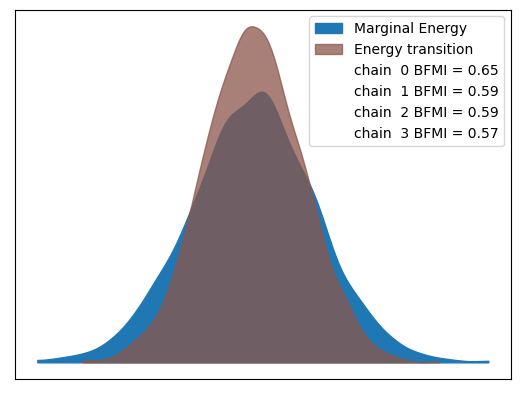

In [15]:
fb_stuff_model.check_convergence();

If we are satisfied that the model has converged, we can move on to the model fit. This is largely the same idea as a model **calibration** check: seeing whether the model predictions correspond adequately to observed values. Since we have a Bayesian model, we can use **posterior predictive checks** for this. This involves simulating several datasets from the model, and comparing the simulated datasets to the actual observed data (in this case, the data used to fit the model). If the model fits, we would expect the observed data to be indistinguishable from some random draw from the model.

The `check_calibration` method automates this for you, generating a visual check whereby a cloud of lines representing a thousand or so simulated datasets are plotted as blue lines alongside the observed data as a thick black line. 

Sampling: [prediction_like, theta_like]


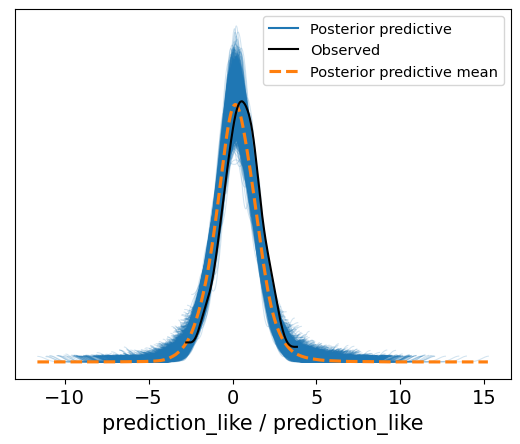

In [16]:
fb_stuff_model.check_calibration();

## Generating Projections

Once we have checked the model and are comfortable with the evaluation, we can use it to generate projections on data it has not yet seen. Again, this will typically be for data leading up to the upcoming season, but here we are just going to use the holdout subset, `pred_pitchers`.

In [17]:
X_pred = X.loc[pred_pitchers]
N_x_pred = N_x.loc[pred_pitchers]
N_y_pred = N_y.loc[pred_pitchers]

The `predict` method has nearly identical arguments to `fit` except we do not have `y` values, since this is what we are trying to forecast. Note that `N_y` is required, though this may be some hypothetical/average value, such as 600 plate appearances or 2000 pitches.

In [18]:
predicted_fb_stuff = fb_stuff_model.predict(X=X_pred, N_x=N_x_pred, N_y=N_y_pred)

Sampling: []


`predict` returns a `DataFrame` of projected values, along with their posterior standard deviation and a 90% prediction interval.

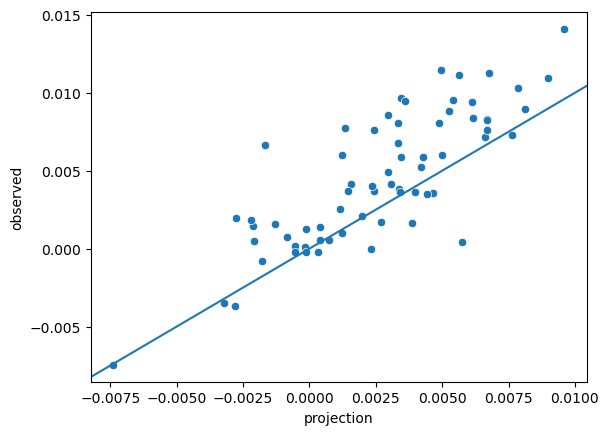

In [19]:
projection = pd.DataFrame(dict(projection=predicted_fb_stuff['mean'].values, observed=y.loc[pred_pitchers].values))
ax = sns.scatterplot(x='projection', y='observed', data=projection)
ax.axline((0, 0), slope=1);

You may be interested in the weights being used by your model to generate the projections. The `get_weights` will return the posterior estimates of the weights, in temporal order from the first year `w[0]` to last `w[2]`. We generally expect the weights to be larger the closer they are to the projection year.

In [20]:
fb_stuff_model.get_weights()

,mean,sd
w[0],0.275,0.042
w[1],0.326,0.053
w[2],0.400,0.040


## Binomial Model

The default normal model is only suitable for continuous-valued quantities that can be reasonably modeled with a normal likelihood, such as stuff, velocity, or WAR. Sometimes we are interested in projecting rates, which involve binomial data, for example, home run rate, K rate, etc. For this, Motuba also had a binomial model.



In [21]:
pred_year = 2021

query_string = f"""
SELECT  
  pa.bam_id,
  pa.season - EXTRACT(YEAR FROM pp.birth_date) age,
  pa.season,
  pa.k_pct,
  pa.k,
  pa.tbf
FROM stats.stats_player_pitching_bylevel pa
JOIN mesa.player pp USING (bam_id)
WHERE pa.game_type = 'R'
    AND pa.source = 'gumbo'
    AND pa.level = 'MLB'
    AND pa.season > {pred_year} - 4
"""

input_data = pandas_gbq.read_gbq(query_string, project_id="phil-new").drop_duplicates(subset=['bam_id', 'season'])

input_grid = (
    input_data[
        input_data.season.isin(np.arange(pred_year - 3, pred_year + 1))
    ]
    .pivot(index="bam_id", columns="season", values=["k", "tbf", "age"])
    .dropna()
)

Downloading: 100%|██████████| 477782/477782 [00:33<00:00, 14065.38rows/s]


In [22]:
X = input_grid['k'].copy()
y = X.pop(pred_year)
N_x = input_grid['tbf'].copy()
N_y = N_x.pop(pred_year)
X["age"] = input_grid[("age", pred_year)]

In [23]:
all_pitchers = X.index.unique().values
fit_pitchers = all_pitchers[:int(len(all_pitchers)*0.8)]
pred_pitchers = all_pitchers[int(len(all_pitchers)*0.8):]

In [24]:
k_pct_model = Motuba(model_type='binomial')

In [25]:
X_fit = X.loc[fit_pitchers].astype(int)
y_fit = y.loc[fit_pitchers].astype(int)

N_x_fit = N_x.loc[fit_pitchers].astype(int)
N_y_fit = N_y.loc[fit_pitchers].astype(int)

In [26]:
k_pct_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z, w, beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 85 seconds.


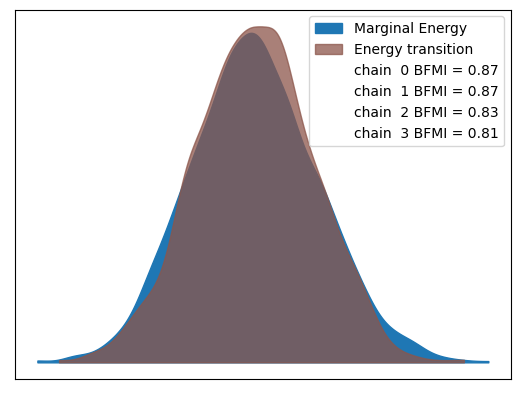

In [27]:
k_pct_model.check_convergence();

In [28]:
k_pct_model.get_weights()

,mean,sd
w[0],0.293,0.025
w[1],0.374,0.027
w[2],0.333,0.024


In [29]:
X_pred = X.loc[pred_pitchers].astype(int)
N_x_pred = N_x.loc[pred_pitchers].astype(int)
N_y_pred = N_y.loc[pred_pitchers].astype(int)

In [30]:
predicted_k_pct = k_pct_model.predict(X=X_pred, N_x=N_x_pred, N_y=N_y_pred)

Sampling: []


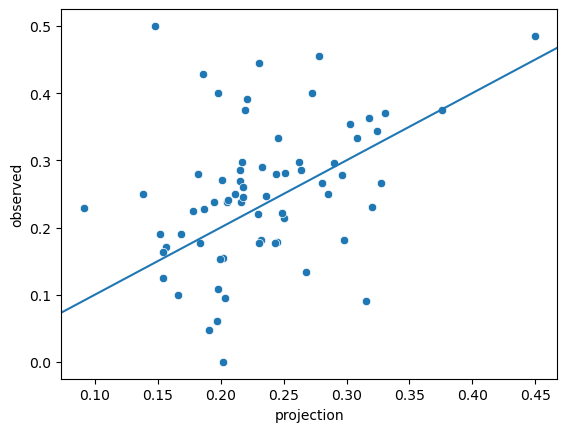

In [31]:
projection = pd.DataFrame(dict(projection=predicted_k_pct['mean'].values, observed=(y/N_y).loc[pred_pitchers].values))
ax = sns.scatterplot(x='projection', y='observed', data=projection)
ax.axline((0.1, 0.1), slope=1)

## When Things Go Wrong

With such a simple model that attempts to project almost anything, inevitably things will go wrong with certain datasets. The first place to look for symptoms of a problem are in the warnings during model fitting. For example, you may read something along the lines of:

> UserWarning: Chain 0 contains 6 diverging samples after tuning. Increase `target_accept` or reparameterize.

This means that the model is (occasionally) having trouble sampling from the model, which results in a **diverging** sample. If this happens only a few times (6 is not many!) things are probably okay, but if there are hundreds or even entirely divergent samples, you will not be able to reliably use inference from the model. 

The underlying PyMC model tries to give advice when it can: while you cannot reparameterize this model, it is possible to change the `target_accept` parameter by passing it to `fit`.  

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", target_accept=0.99)

`target_accept` is the target acceptance rate of the MCMC algorithm, which by default is 0.8. For difficult models, upping this value to 0.9, 0.95 or 0.99 can sometimes solve this issue. Note that higher acceptance rates result in longer runtimes, since it involves taking more steps at every iteration of the model.

If you run into issues with convergence, for example if the energy plots do not look slimiar, the easiest remedy is to run the MCMC model longer--specifically, to add more **tuning steps**. The default number is 3000 tuning steps, but you can change this with the `tune` argument.

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", tune=5000)

Of course, there will be some scenarios where Motuba will just not work. If there are issues with the data (e.g. missing values), or the data do not conform to one of the data generating models used in Motuba then you may need to build a bespoke model to account for the particular characteristics of the quantity you are trying to project.


---

## References

- [Tango on Baseball](https://tangotiger.net/marcel/)
- [Baseball-Reference.com](https://www.baseball-reference.com/about/marcels.shtml)


In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jun 10 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

Watermark: 2.4.3

